In [1]:
import pycircos
import warnings
import numpy as np
import pandas as pd
from os import listdir
from os.path import isdir
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.backends.backend_pdf import PdfPages

warnings.filterwarnings("ignore")

rcParams = {'font.size': 20, 'font.weight': 'normal', 'font.family': 'sans-serif',
            'axes.unicode_minus':False, 'axes.labelweight':'normal'}

plt.rcParams.update(rcParams)

Garc    = pycircos.Garc
Gcircle = pycircos.Gcircle

osa_len = 2932766
osb_len = 3046682

def Make_Counts(df_osa, df_osb, samples):
    osa_indicator = {}
    osb_indicator = {}
    osa_gbl_counts = np.zeros(osa_len)
    osb_gbl_counts = np.zeros(osb_len)
    try:
        osa_samples = set(df_osa['Sample'].tolist())
    except KeyError:
        osa_samples = set({})
    try:
        osb_samples = set(df_osb['Sample'].tolist())
    except KeyError:
        osb_samples = set({})
        
    samples = osa_samples | osb_samples
    
    for g in osa_samples:
        try:
            osa = np.zeros(osa_len)
            temp_osa = df_osa[df_osa['Sample'] == g]
            starts = temp_osa['Start'].tolist()
            ends = temp_osa['End'].tolist()
            lengths = temp_osa['Length'].tolist()
            
            for i in range(len(starts)):
                start, end = int(min(starts[i],ends[i])), int(max(starts[i],ends[i]))
                if abs(start-end) == lengths[i]:    
                    osa[start:end] += 1
                    osa_gbl_counts[start:end] += 1
                else:
                    print("Here", end-start, lengths[i])
                    osa[end:osa_len] += 1
                    osa[0:start] += 1
                    osa_gbl_counts[end:osa_len] += 1
                    osa_gbl_counts[0:start] += 1
            osa[np.isnan(osa)] = 0
            osa_indicator[g] = osa
        except KeyError:
            print('OSA',g)
            osa_indicator[g] = osa
            
    for g in osb_samples:    
        try:
            osb = np.zeros(osb_len)
            temp_osb = df_osb[df_osb['Sample'] == g].reset_index()
            starts = temp_osb['Start'].tolist()
            ends = temp_osb['End'].tolist()
            lengths = temp_osb['Length'].tolist()
            
            for i in range(len(starts)):
                start, end = int(min(starts[i],ends[i])), int(max(starts[i],ends[i]))
                if abs(start-end) == lengths[i]:    
                    osb[start:end] += 1
                    osb_gbl_counts[start:end] += 1
                else:
                    print("Here", end-start, lengths[i])
                    osb[end:osa_len] += 1
                    osb[0:start] += 1
                    osb_gbl_counts[end:osb_len] += 1
                    osb_gbl_counts[0:start] += 1
            osb[np.isnan(osb)] = 0
            osb_indicator[g] = osb
        except KeyError:
            print('OSB',g)
            osb_indicator[g] = osb
    return osa_indicator, osb_indicator

def Max_Clique_Interval_Graph(group):
    length = group.iloc[0]['Contig_Length']
    if len(group) == 1:
        return pd.Series({'Max_Clique':1, 'Start':group['Start'].tolist()[0], 
                          'End': group['End'].tolist()[0], 'Num_Assignments': 1, 
                          'Length':length})
    
    group['Diff'] = group['Start'].shift(-1) - group['End']
    num_assign = len(group)
    max_clique = -1
    max_start, max_end = 0, 0
    clique = -1
    start, end = 0, 0
    
    difference = group['Diff'].tolist()
    starts = group['Start'].tolist()
    ends = group['End'].tolist()
    
    flag = False
    for i in range(0,len(difference)):
        if difference[i] <= 0 and flag == False:
            clique = 2
            start = starts[i]
            end = ends[i]
            flag = True
        elif difference[i] <= 0 and flag == True:
            clique += 1
        elif difference[i] > 0:
            if max_clique < clique:
                max_clique = clique
                max_start = start
                max_end = end
            flag = False
            clique = -1
    
    if max_clique < clique:
        max_clique = clique
        max_start = start
        max_end = end
            
    if max_clique == -1:
        max_clique = 1
        i = np.argmin(difference)
        max_start = starts[i]
        max_end = ends[i]
    
    return pd.Series({'Max_Clique':max_clique, 'Start':max_start, 
                      'End': max_end, 'Num_Assignments':num_assign,
                      'Length':length}) 

In [2]:
novel_contig_path = '/Users/harihara/Research-Activities/Data/Hot-Spring/Missing_Contig_Coords_2/'
novel_contigs = {}
samples = listdir(novel_contig_path+'OSA/')
for s in samples:
    df_osa = pd.read_csv(novel_contig_path+'OSA/'+s, sep = "\t")
    df_osa.loc[(df_osa['Start'] < 0), 'Start'] += osa_len
    df_osa.loc[(df_osa['End'] < 0), 'End'] += osa_len
    df_osa_grp = df_osa.sort_values(by = ['Contig','Start']).groupby(['Contig']).apply(Max_Clique_Interval_Graph)
    
    df_osb = pd.read_csv(novel_contig_path+'OSB/'+s, sep = "\t")
    df_osb.loc[(df_osb['Start'] < 0), 'Start'] += osb_len
    df_osb.loc[(df_osb['End'] < 0), 'End'] += osb_len
    df_osb_grp = df_osb.sort_values(by = ['Contig','Start']).groupby(['Contig']).apply(Max_Clique_Interval_Graph)
    
    novel_contigs[s.replace(".txt","")] = {'OSA':df_osa_grp,'OSB':df_osb_grp}

In [4]:
grp_path = '/Users/harihara/Downloads/contig_containment_groups_subset.txt'
df_novel_filtered = pd.read_csv(grp_path, sep = "\t")
d = df_novel_filtered.groupby('GroupID')['Contig'].apply(list).to_dict()
print(len(d))

100


In [5]:
df_osa_only = pd.DataFrame()
df_osb_only = pd.DataFrame()

df_osa_both = pd.DataFrame()
df_osb_both = pd.DataFrame()

for g in d:
    contigs = d[g]
    osa_contig_count, osb_contig_count = 0, 0
    osa_contigs, osb_contigs = [], []
    df_osa, df_osb = pd.DataFrame(), pd.DataFrame()
    
    for c in contigs:
        splits = c.split('_')
        
        if len(splits) == 5:
            sample = splits[0]+'_'+splits[1]
            genome = splits[2].upper()
            contig = splits[3]+'_'+splits[4]
        if len(splits) == 4:
            sample = splits[0]
            genome = splits[1].upper()
            contig = splits[2]+'_'+splits[3]
        if genome == "OSA":
            osa_contig_count += 1
        if genome == "OSB":
            osb_contig_count += 1
        
        try:
            row = novel_contigs[sample][genome].loc[contig]
            row['Group'] = g
            row['Sample'] = sample
            if genome == 'OSA':
                df_osa = df_osa.append(row)
            elif genome == 'OSB':
                df_osb = df_osb.append(row)
            
        except:
            pass
        #    print(g, len(d[g]), sample, genome, contig)
    
    if len(df_osa) > 0:
        df_osa = df_osa.reset_index()
        df_osa = df_osa.rename(columns = {'index':'Contig'})
        idx_osa = df_osa.groupby(['Sample','Contig'])['Start'].transform(min) == df_osa['Start']
        df_osa = df_osa.loc[idx_osa]
    if len(df_osb) > 0:
        df_osb = df_osb.reset_index()
        df_osb = df_osb.rename(columns = {'index':'Contig'})
        idx_osb = df_osb.groupby(['Sample','Contig'])['Start'].transform(min) == df_osb['Start']
        df_osb = df_osb.loc[idx_osb]
    
    if len(df_osa) == 0 and len(df_osb) > 0:
        df_osb_only = df_osb_only.append(df_osb, ignore_index = True)
    
    if len(df_osb) == 0 and len(df_osa) > 0:
        df_osa_only = df_osa_only.append(df_osa, ignore_index = True)
    
    if len(df_osa) > 0 and len(df_osb) > 0:
        df_osb_both = df_osb_both.append(df_osb)
        df_osa_both = df_osa_both.append(df_osa)
    

In [6]:
osa_indicator_both, osb_indicator_both = Make_Counts(df_osa_both, df_osb_both, list(novel_contigs.keys()))
osa_indicator_only, osb_indicator_only = Make_Counts(df_osa_only, df_osb_only, list(novel_contigs.keys()))

In [7]:
ms_samples = ['HotsprSampleMS50','HotsprSampleMS55','HotsprSampleMS60','HotsprSampleMS65']
os_samples = ['HotsprSampleOS50','HotsprSampleOS55','HotsprSampleOS60','HotsprSampleOS65']
light_samples = ['Hotspr20Samplet1','Hotspr2Sampleme2','Hotspr20SampleT8','Hotspr20SampleT9']
dark_samples = ['Hotspr20Samplem2','Hotspr2Sampleee2', 'Hotspr20SampleP4','Hotspr2SamplePe2']


In [8]:
out_dir = '/Users/harihara/Research-Activities/Plots/Hot_Spring_Plots/Synechococcus-Paper/'
if not isdir(out_dir):
    mkdir(out_dir)

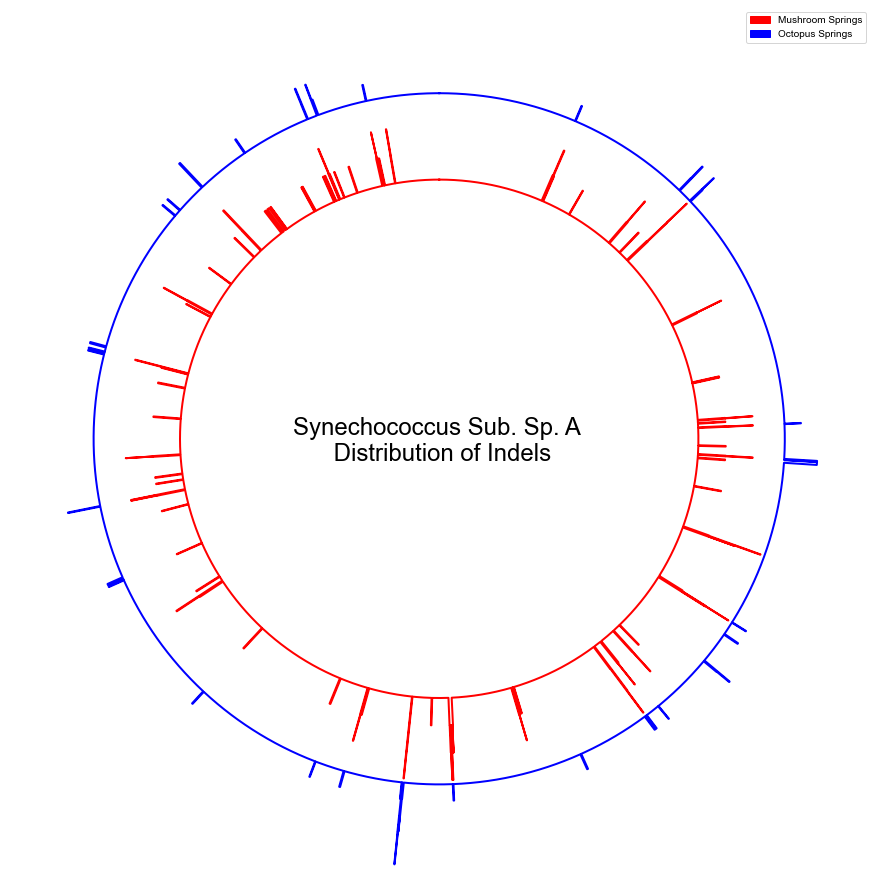

In [9]:
garc = Garc(arc_id="OSA", interspace=0, linewidth=0, facecolor="#FFFFFF00", raxis_range=(0,10), 
            labelsize = 24, label="Synechococcus Sub. Sp. A \n Distribution of Indels", 
            label_visible=True)

gcircle = Gcircle(figsize = (12,12))
gcircle.add_garc(garc)
gcircle.set_garcs()

ms_osa = (osa_indicator_both[ms_samples[0]]+osa_indicator_both[ms_samples[1]]+
          osa_indicator_both[ms_samples[2]]+osa_indicator_both[ms_samples[3]]+
          osa_indicator_only[ms_samples[0]]+osa_indicator_only[ms_samples[1]]+
          osa_indicator_only[ms_samples[2]]+osa_indicator_only[ms_samples[3]])

os_osa = (osa_indicator_both[os_samples[0]]+osa_indicator_both[os_samples[1]]+
          osa_indicator_both[os_samples[2]]+osa_indicator_both[os_samples[3]]+
          osa_indicator_only[os_samples[1]]+osa_indicator_only[os_samples[0]]+
          osa_indicator_only[os_samples[2]]+osa_indicator_only[os_samples[3]])

gcircle.lineplot('OSA',ms_osa,raxis_range=(600,800), linewidth = 2, linecolor = 'red')
gcircle.lineplot('OSA',os_osa,raxis_range=(800,1000), linewidth = 2, linecolor = 'blue')
ax=gcircle.ax
red_patch = mpatches.Patch(color='red', label='Mushroom Springs')
blue_patch = mpatches.Patch(color='blue', label='Octopus Springs')
ax.legend(handles=[red_patch, blue_patch])
fig = ax.get_figure()
fig.tight_layout()
fig.savefig(out_dir+'OSA-All-Indels.pdf')

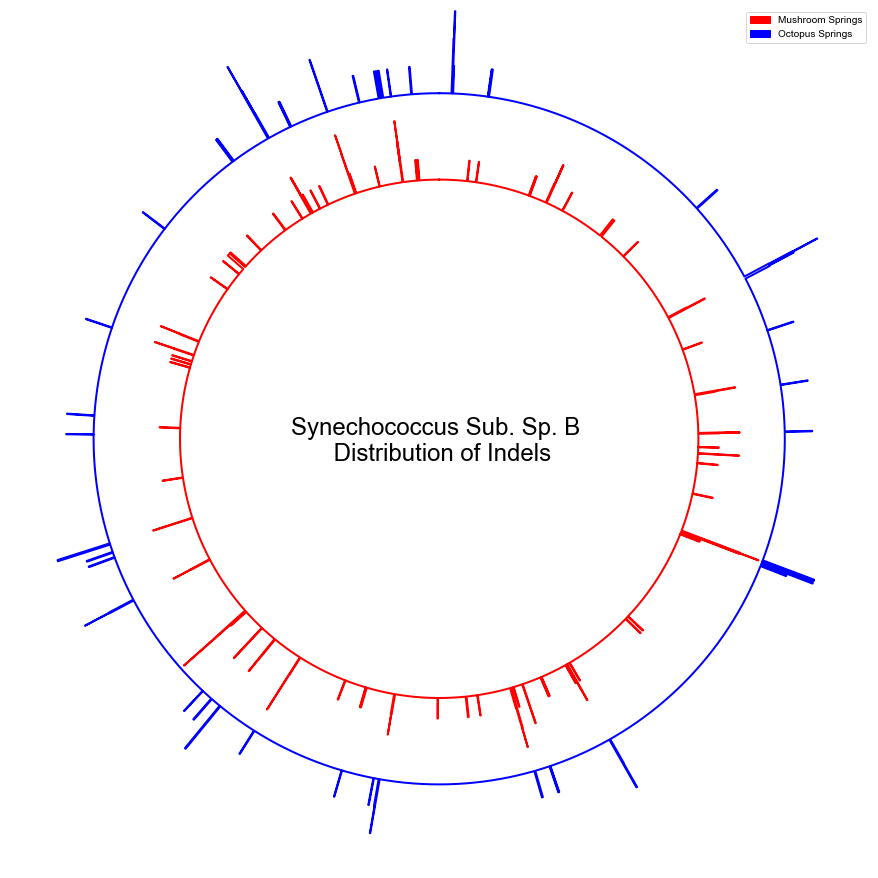

In [10]:
garc = Garc(arc_id="OSB", interspace=0, linewidth=0, facecolor="#FFFFFF00", raxis_range=(0,10), 
            labelsize = 24, label="Synechococcus Sub. Sp. B \n Distribution of Indels", 
            label_visible=True)

gcircle = Gcircle(figsize = (12,12))
gcircle.add_garc(garc)
gcircle.set_garcs()

ms_osa = (osb_indicator_both[ms_samples[0]]+osb_indicator_both[ms_samples[1]]+
          osb_indicator_both[ms_samples[2]]+osb_indicator_both[ms_samples[3]]+
          osb_indicator_only[ms_samples[0]]+osb_indicator_only[ms_samples[1]]+
          osb_indicator_only[ms_samples[2]]+osb_indicator_only[ms_samples[3]])

os_osa = (osb_indicator_both[os_samples[0]]+osb_indicator_both[os_samples[1]]+
          osb_indicator_both[os_samples[2]]+osb_indicator_both[os_samples[3]]+
          osb_indicator_only[os_samples[0]]+osb_indicator_only[os_samples[1]]+
          osb_indicator_only[os_samples[2]]+osb_indicator_only[os_samples[3]])

gcircle.lineplot('OSB',ms_osa,raxis_range=(600,800), linewidth = 2, linecolor = 'red')
gcircle.lineplot('OSB',os_osa,raxis_range=(800,1000), linewidth = 2, linecolor = 'blue')
ax=gcircle.ax
red_patch = mpatches.Patch(color='red', label='Mushroom Springs')
blue_patch = mpatches.Patch(color='blue', label='Octopus Springs')
ax.legend(handles=[red_patch, blue_patch])
fig = ax.get_figure()
fig.tight_layout()
fig.savefig(out_dir+'OSB-All-Indels.pdf')

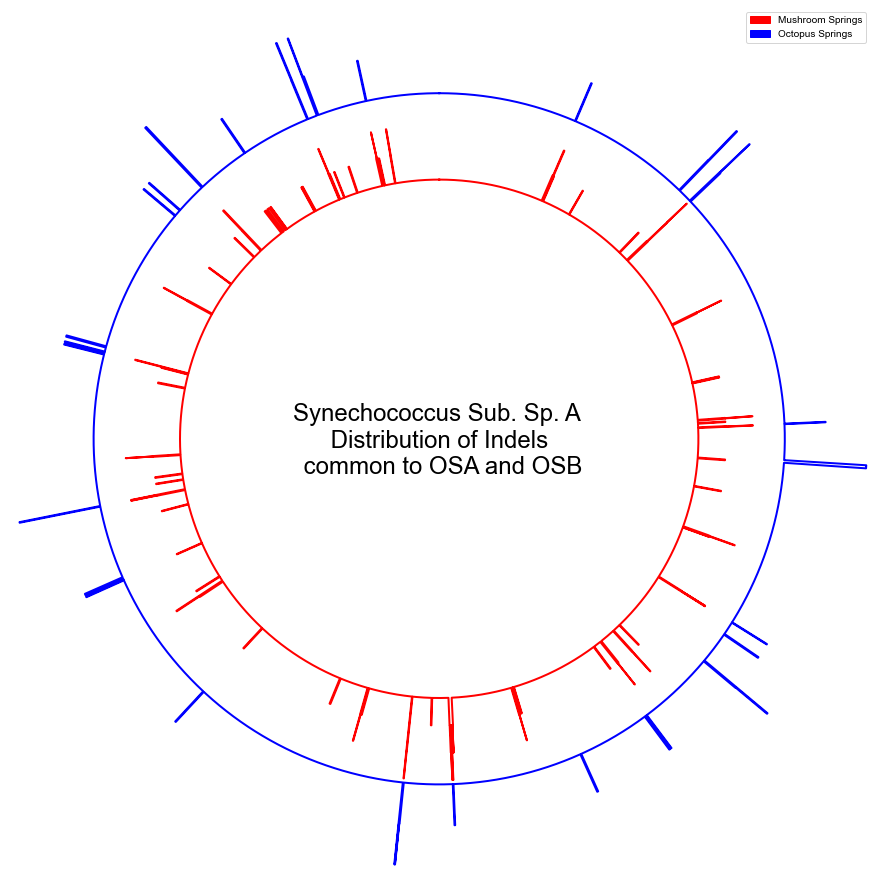

In [11]:
garc = Garc(arc_id="OSA", interspace=0, linewidth=0, facecolor="#FFFFFF00", raxis_range=(0,10), 
            labelsize = 24, label="Synechococcus Sub. Sp. A \n Distribution of Indels \n common to OSA and OSB", 
            label_visible=True)

gcircle = Gcircle(figsize = (12,12))
gcircle.add_garc(garc)
gcircle.set_garcs()

ms_osa_both = (osa_indicator_both[ms_samples[0]]+osa_indicator_both[ms_samples[1]]+
               osa_indicator_both[ms_samples[2]]+osa_indicator_both[ms_samples[3]])
os_osa_both = (osa_indicator_both[os_samples[0]]+osa_indicator_both[os_samples[1]]+
               osa_indicator_both[os_samples[2]]+osa_indicator_both[os_samples[3]])
gcircle.lineplot('OSA',ms_osa_both,raxis_range=(600,800), linewidth = 2, linecolor = 'red')
gcircle.lineplot('OSA',os_osa_both,raxis_range=(800,1000), linewidth = 2, linecolor = 'blue')
ax=gcircle.ax
red_patch = mpatches.Patch(color='red', label='Mushroom Springs')
blue_patch = mpatches.Patch(color='blue', label='Octopus Springs')
ax.legend(handles=[red_patch, blue_patch])
fig = ax.get_figure()
fig.tight_layout()
fig.savefig(out_dir + 'Circos-OSA-Both(Temperature-Gradient-Springs).pdf')

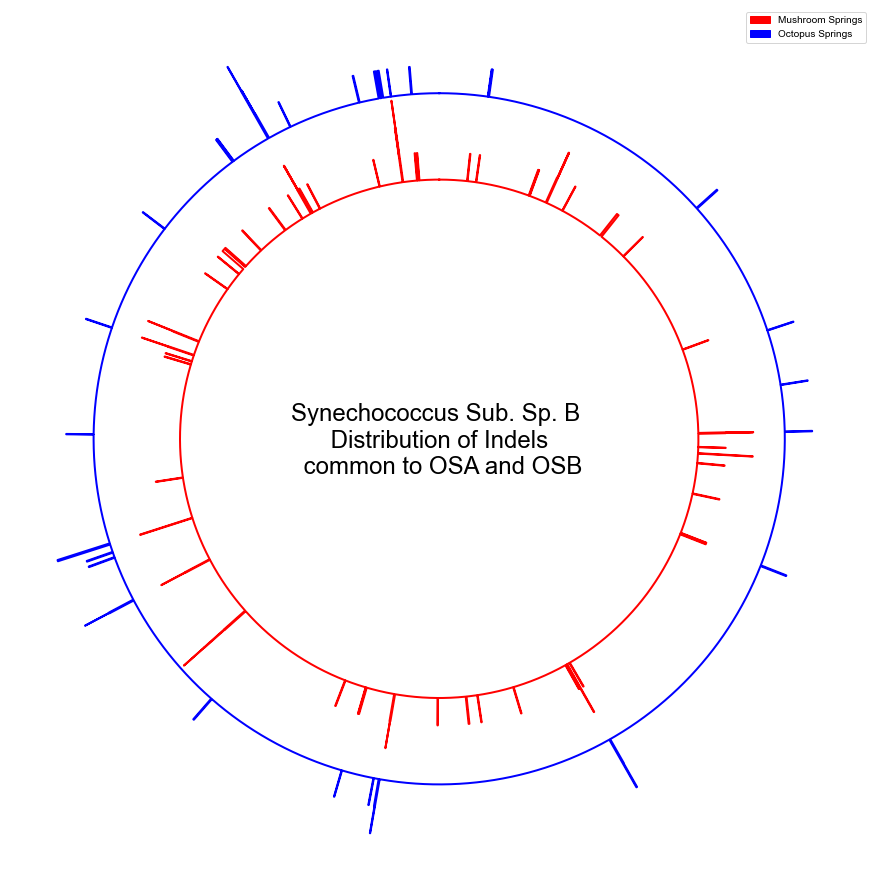

In [12]:
garc = Garc(arc_id="OSB", interspace=0, linewidth=0, facecolor="#FFFFFF00", raxis_range=(0,10), 
            labelsize = 24, label="Synechococcus Sub. Sp. B \n Distribution of Indels \n common to OSA and OSB", 
            label_visible=True)

gcircle = Gcircle(figsize = (12,12))
gcircle.add_garc(garc)
gcircle.set_garcs()

ms_osb_both = (osb_indicator_both[ms_samples[0]]+osb_indicator_both[ms_samples[1]]+
               osb_indicator_both[ms_samples[2]]+osb_indicator_both[ms_samples[3]])
os_osb_both = (osb_indicator_both[os_samples[0]]+osb_indicator_both[os_samples[1]]+
               osb_indicator_both[os_samples[2]]+osb_indicator_both[os_samples[3]])
gcircle.lineplot('OSB',ms_osb_both,raxis_range=(600,800), linewidth = 2, linecolor = 'red')
gcircle.lineplot('OSB',os_osb_both,raxis_range=(800,1000), linewidth = 2, linecolor = 'blue')
ax=gcircle.ax
red_patch = mpatches.Patch(color='red', label='Mushroom Springs')
blue_patch = mpatches.Patch(color='blue', label='Octopus Springs')
ax.legend(handles=[red_patch, blue_patch])
fig = ax.get_figure()
fig.tight_layout()
fig.savefig(out_dir + 'Circos-OSB-Both(Temperature-Gradient-Springs).pdf')

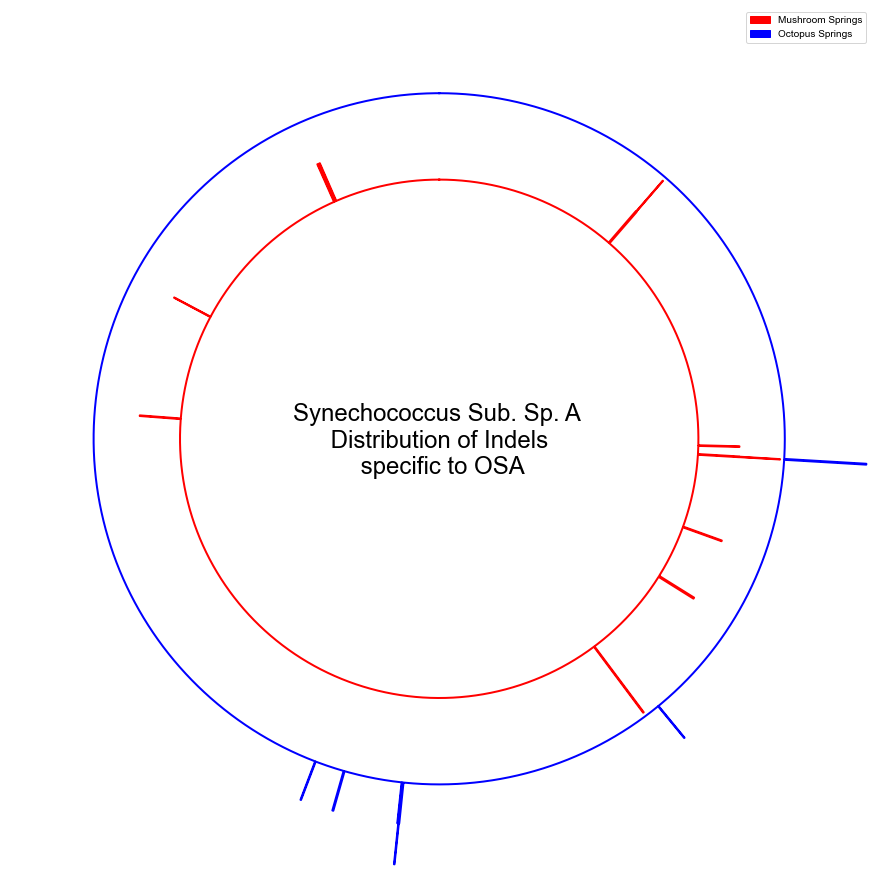

In [13]:
garc = Garc(arc_id="OSA", interspace=0, linewidth=0, facecolor="#FFFFFF00", raxis_range=(0,10), 
            labelsize = 24, label="Synechococcus Sub. Sp. A \n Distribution of Indels \n specific to OSA", 
            label_visible=True)

gcircle = Gcircle(figsize = (12,12))
gcircle.add_garc(garc)
gcircle.set_garcs()

ms_osa_both = (osa_indicator_only[ms_samples[0]]+osa_indicator_only[ms_samples[1]]+
               osa_indicator_only[ms_samples[2]]+osa_indicator_only[ms_samples[3]])
os_osa_both = (osa_indicator_only[os_samples[1]]+
               osa_indicator_only[os_samples[2]]+osa_indicator_only[os_samples[3]])
gcircle.lineplot('OSA',ms_osa_both,raxis_range=(600,800), linewidth = 2, linecolor = 'red')
gcircle.lineplot('OSA',os_osa_both,raxis_range=(800,1000), linewidth = 2, linecolor = 'blue')
ax=gcircle.ax
red_patch = mpatches.Patch(color='red', label='Mushroom Springs')
blue_patch = mpatches.Patch(color='blue', label='Octopus Springs')
ax.legend(handles=[red_patch, blue_patch])
fig = ax.get_figure()
fig.tight_layout()

fig.savefig(out_dir + 'Circos-OSA-Only(Temperature-Gradient-Springs).pdf')

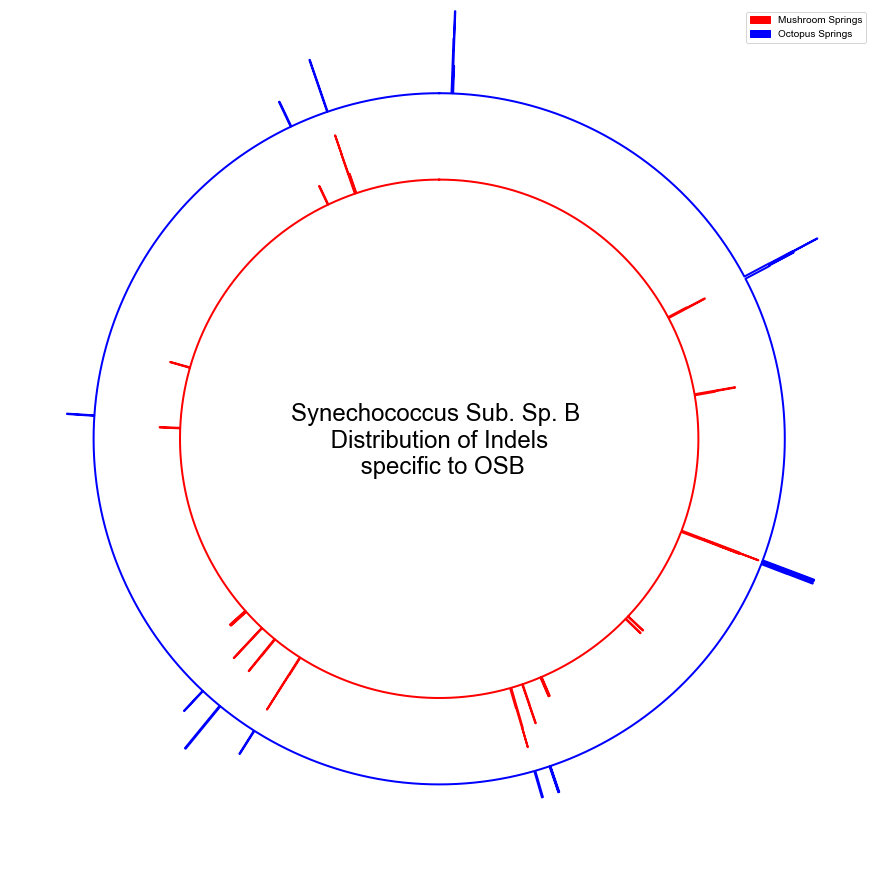

In [14]:
garc = Garc(arc_id="OSB", interspace=0, linewidth=0, facecolor="#FFFFFF00", raxis_range=(0,10), 
            labelsize = 24, label="Synechococcus Sub. Sp. B \n Distribution of Indels \n specific to OSB", 
            label_visible=True)

gcircle = Gcircle(figsize = (12,12))
gcircle.add_garc(garc)
gcircle.set_garcs()

ms_osb_only = (osb_indicator_only[ms_samples[0]]+osb_indicator_only[ms_samples[1]]+
               osb_indicator_only[ms_samples[2]]+osb_indicator_only[ms_samples[3]])
os_osb_only = (osb_indicator_only[os_samples[0]]+osb_indicator_only[os_samples[1]]+
               osb_indicator_only[os_samples[2]]+osb_indicator_only[os_samples[3]])
gcircle.lineplot('OSB',ms_osb_only,raxis_range=(600,800), linewidth = 2, linecolor = 'red')
gcircle.lineplot('OSB',os_osb_only,raxis_range=(800,1000), linewidth = 2, linecolor = 'blue')
ax=gcircle.ax
red_patch = mpatches.Patch(color='red', label='Mushroom Springs')
blue_patch = mpatches.Patch(color='blue', label='Octopus Springs')
ax.legend(handles=[red_patch, blue_patch])
fig = ax.get_figure()
fig.tight_layout()

fig.savefig(out_dir + 'Circos-OSB-Only(Temperature-Gradient-Springs).pdf')

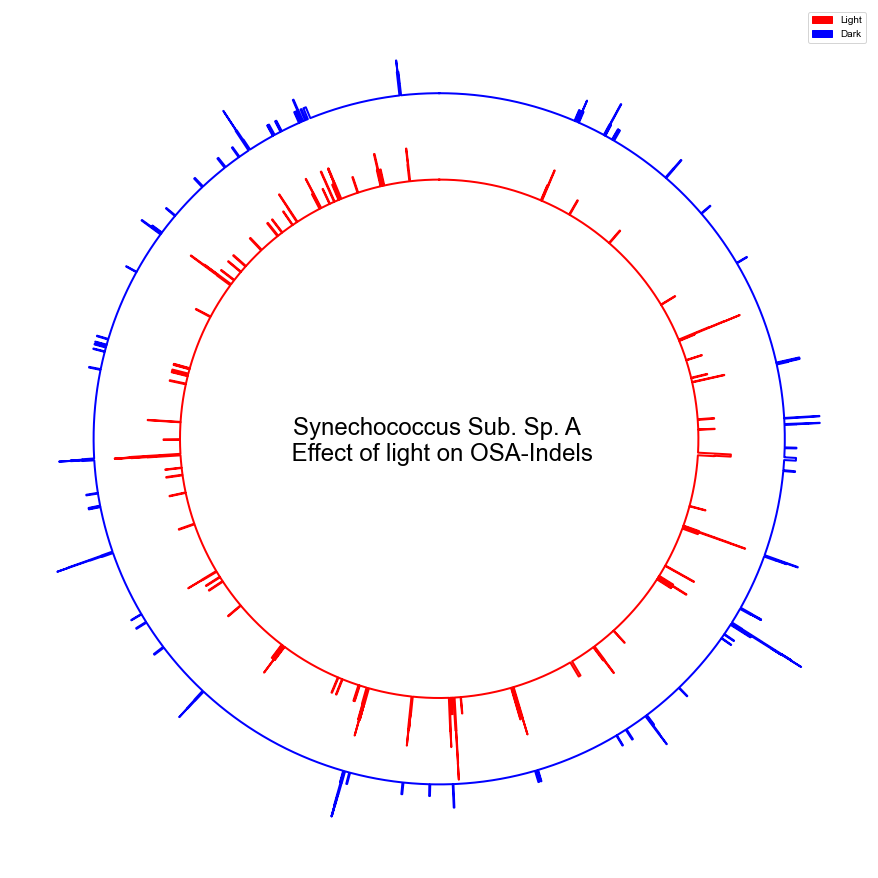

In [15]:
garc = Garc(arc_id="OSA", interspace=0, linewidth=0, facecolor="#FFFFFF00", raxis_range=(0,10), 
            labelsize = 24, label="Synechococcus Sub. Sp. A \n Effect of light on OSA-Indels", 
            label_visible=True)

gcircle = Gcircle(figsize = (12,12))
gcircle.add_garc(garc)
gcircle.set_garcs()

ms_osa_light = (osa_indicator_both[light_samples[0]]+osa_indicator_both[light_samples[1]]+
                osa_indicator_both[light_samples[2]]+osa_indicator_both[light_samples[3]]+
                osa_indicator_only[light_samples[0]]+osa_indicator_only[light_samples[1]]+
                osa_indicator_only[light_samples[2]]+osa_indicator_only[light_samples[3]]) 
ms_osa_dark = (osa_indicator_both[dark_samples[0]]+osa_indicator_both[dark_samples[1]]+
               osa_indicator_both[dark_samples[2]]+osa_indicator_both[dark_samples[3]]+
               osa_indicator_only[dark_samples[1]]+
               osa_indicator_only[dark_samples[2]]+osa_indicator_only[dark_samples[3]])
            
gcircle.lineplot('OSA',ms_osa_light,raxis_range=(600,800), linewidth = 2, linecolor = 'red')
gcircle.lineplot('OSA',ms_osa_dark,raxis_range=(800,1000), linewidth = 2, linecolor = 'blue')
ax=gcircle.ax
red_patch = mpatches.Patch(color='red', label='Light')
blue_patch = mpatches.Patch(color='blue', label='Dark')
ax.legend(handles=[red_patch, blue_patch])
fig = ax.get_figure()
fig.tight_layout()
fig.savefig(out_dir + 'Circos-OSA-Both(Photo-Systems).pdf')

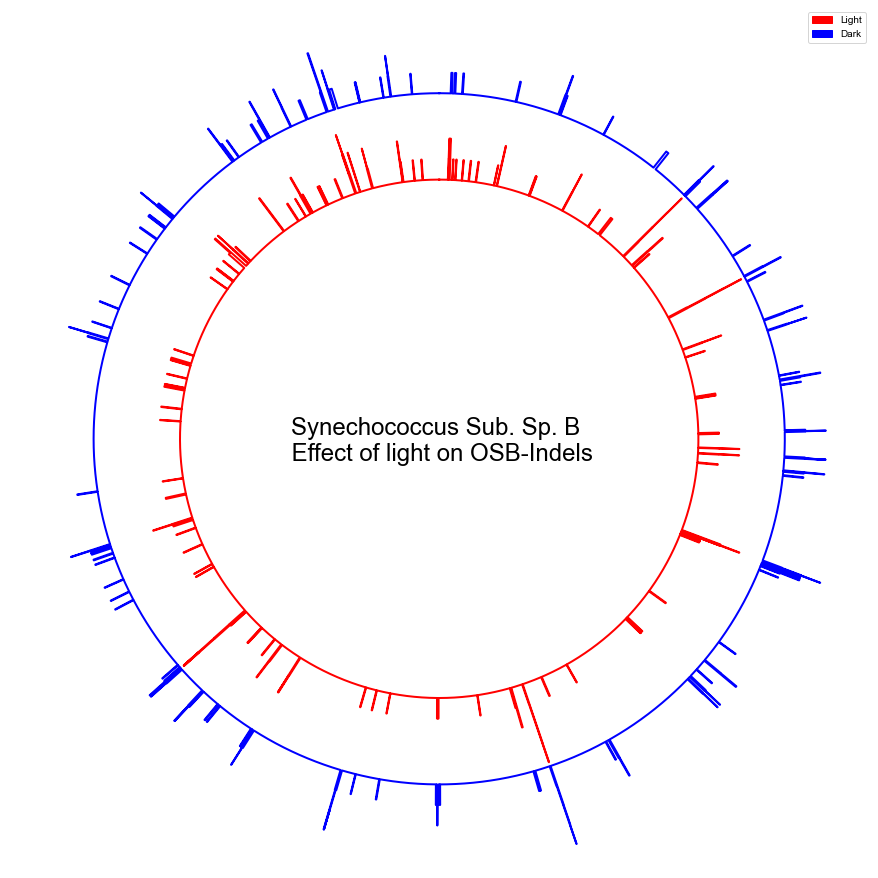

In [16]:
garc = Garc(arc_id="OSB", interspace=0, linewidth=0, facecolor="#FFFFFF00", raxis_range=(0,10), 
            labelsize = 24, label="Synechococcus Sub. Sp. B \n Effect of light on OSB-Indels", 
            label_visible=True)

gcircle = Gcircle(figsize = (12,12))
gcircle.add_garc(garc)
gcircle.set_garcs()

ms_osb_light = (osb_indicator_both[light_samples[0]]+osb_indicator_both[light_samples[1]]+
                osb_indicator_both[light_samples[2]]+osb_indicator_both[light_samples[3]]+
                osb_indicator_only[light_samples[0]]+osb_indicator_only[light_samples[1]]+
                osb_indicator_only[light_samples[2]]+osb_indicator_only[light_samples[3]]) 
ms_osb_dark = (osb_indicator_both[dark_samples[0]]+osb_indicator_both[dark_samples[1]]+
               osb_indicator_both[dark_samples[2]]+osb_indicator_both[dark_samples[3]]+
               osb_indicator_only[dark_samples[0]]+osb_indicator_only[dark_samples[1]]+
               osb_indicator_only[dark_samples[2]]+osb_indicator_only[dark_samples[3]])
            
gcircle.lineplot('OSB',ms_osb_light,raxis_range=(600,800), linewidth = 2, linecolor = 'red')
gcircle.lineplot('OSB',ms_osb_dark,raxis_range=(800,1000), linewidth = 2, linecolor = 'blue')
ax=gcircle.ax
red_patch = mpatches.Patch(color='red', label='Light')
blue_patch = mpatches.Patch(color='blue', label='Dark')
ax.legend(handles=[red_patch, blue_patch])
fig = ax.get_figure()
fig.tight_layout()
fig.savefig(out_dir + 'Circos-OSB-Both(Photo-Systems).pdf')